# Penguin Classification Notebook
Distinguish between three species of penguins based on measurements recorded for three different species, aggregated in a second instance.
Data from : https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download

Original data published in https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081

Descritpion of the data table available here:
https://github.com/allisonhorst/palmerpenguins/blob/main/README.md


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer, classification_report, roc_curve, roc_auc_score

%matplotlib inline

## Data  Import, Clean up and Exploration

In [3]:
data = pd.read_csv("penguins_lter.csv")
data.describe(include="all")

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
count,344,344.000000,344,344,344,344,344,344,344,342.000000,342.000000,342.000000,342.000000,334,330.000000,331.000000,26
unique,3,NaN,3,1,3,1,190,2,50,NaN,NaN,NaN,NaN,3,NaN,NaN,7
top,PAL0910,NaN,Adelie Penguin (Pygoscelis adeliae),Anvers,Biscoe,"Adult, 1 Egg Stage",N61A2,Yes,11/27/07,NaN,NaN,NaN,NaN,MALE,NaN,NaN,Nest never observed with full clutch.
freq,120,NaN,152,344,168,344,3,308,18,NaN,NaN,NaN,NaN,168,NaN,NaN,13
mean,NaN,63.151163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN,8.733382,-25.686292,NaN
std,NaN,40.430199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN,0.551770,0.793961,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN,7.632200,-27.018540,NaN
25%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN,8.299890,-26.320305,NaN
50%,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN,8.652405,-25.833520,NaN
75%,NaN,95.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN,9.172123,-25.062050,NaN


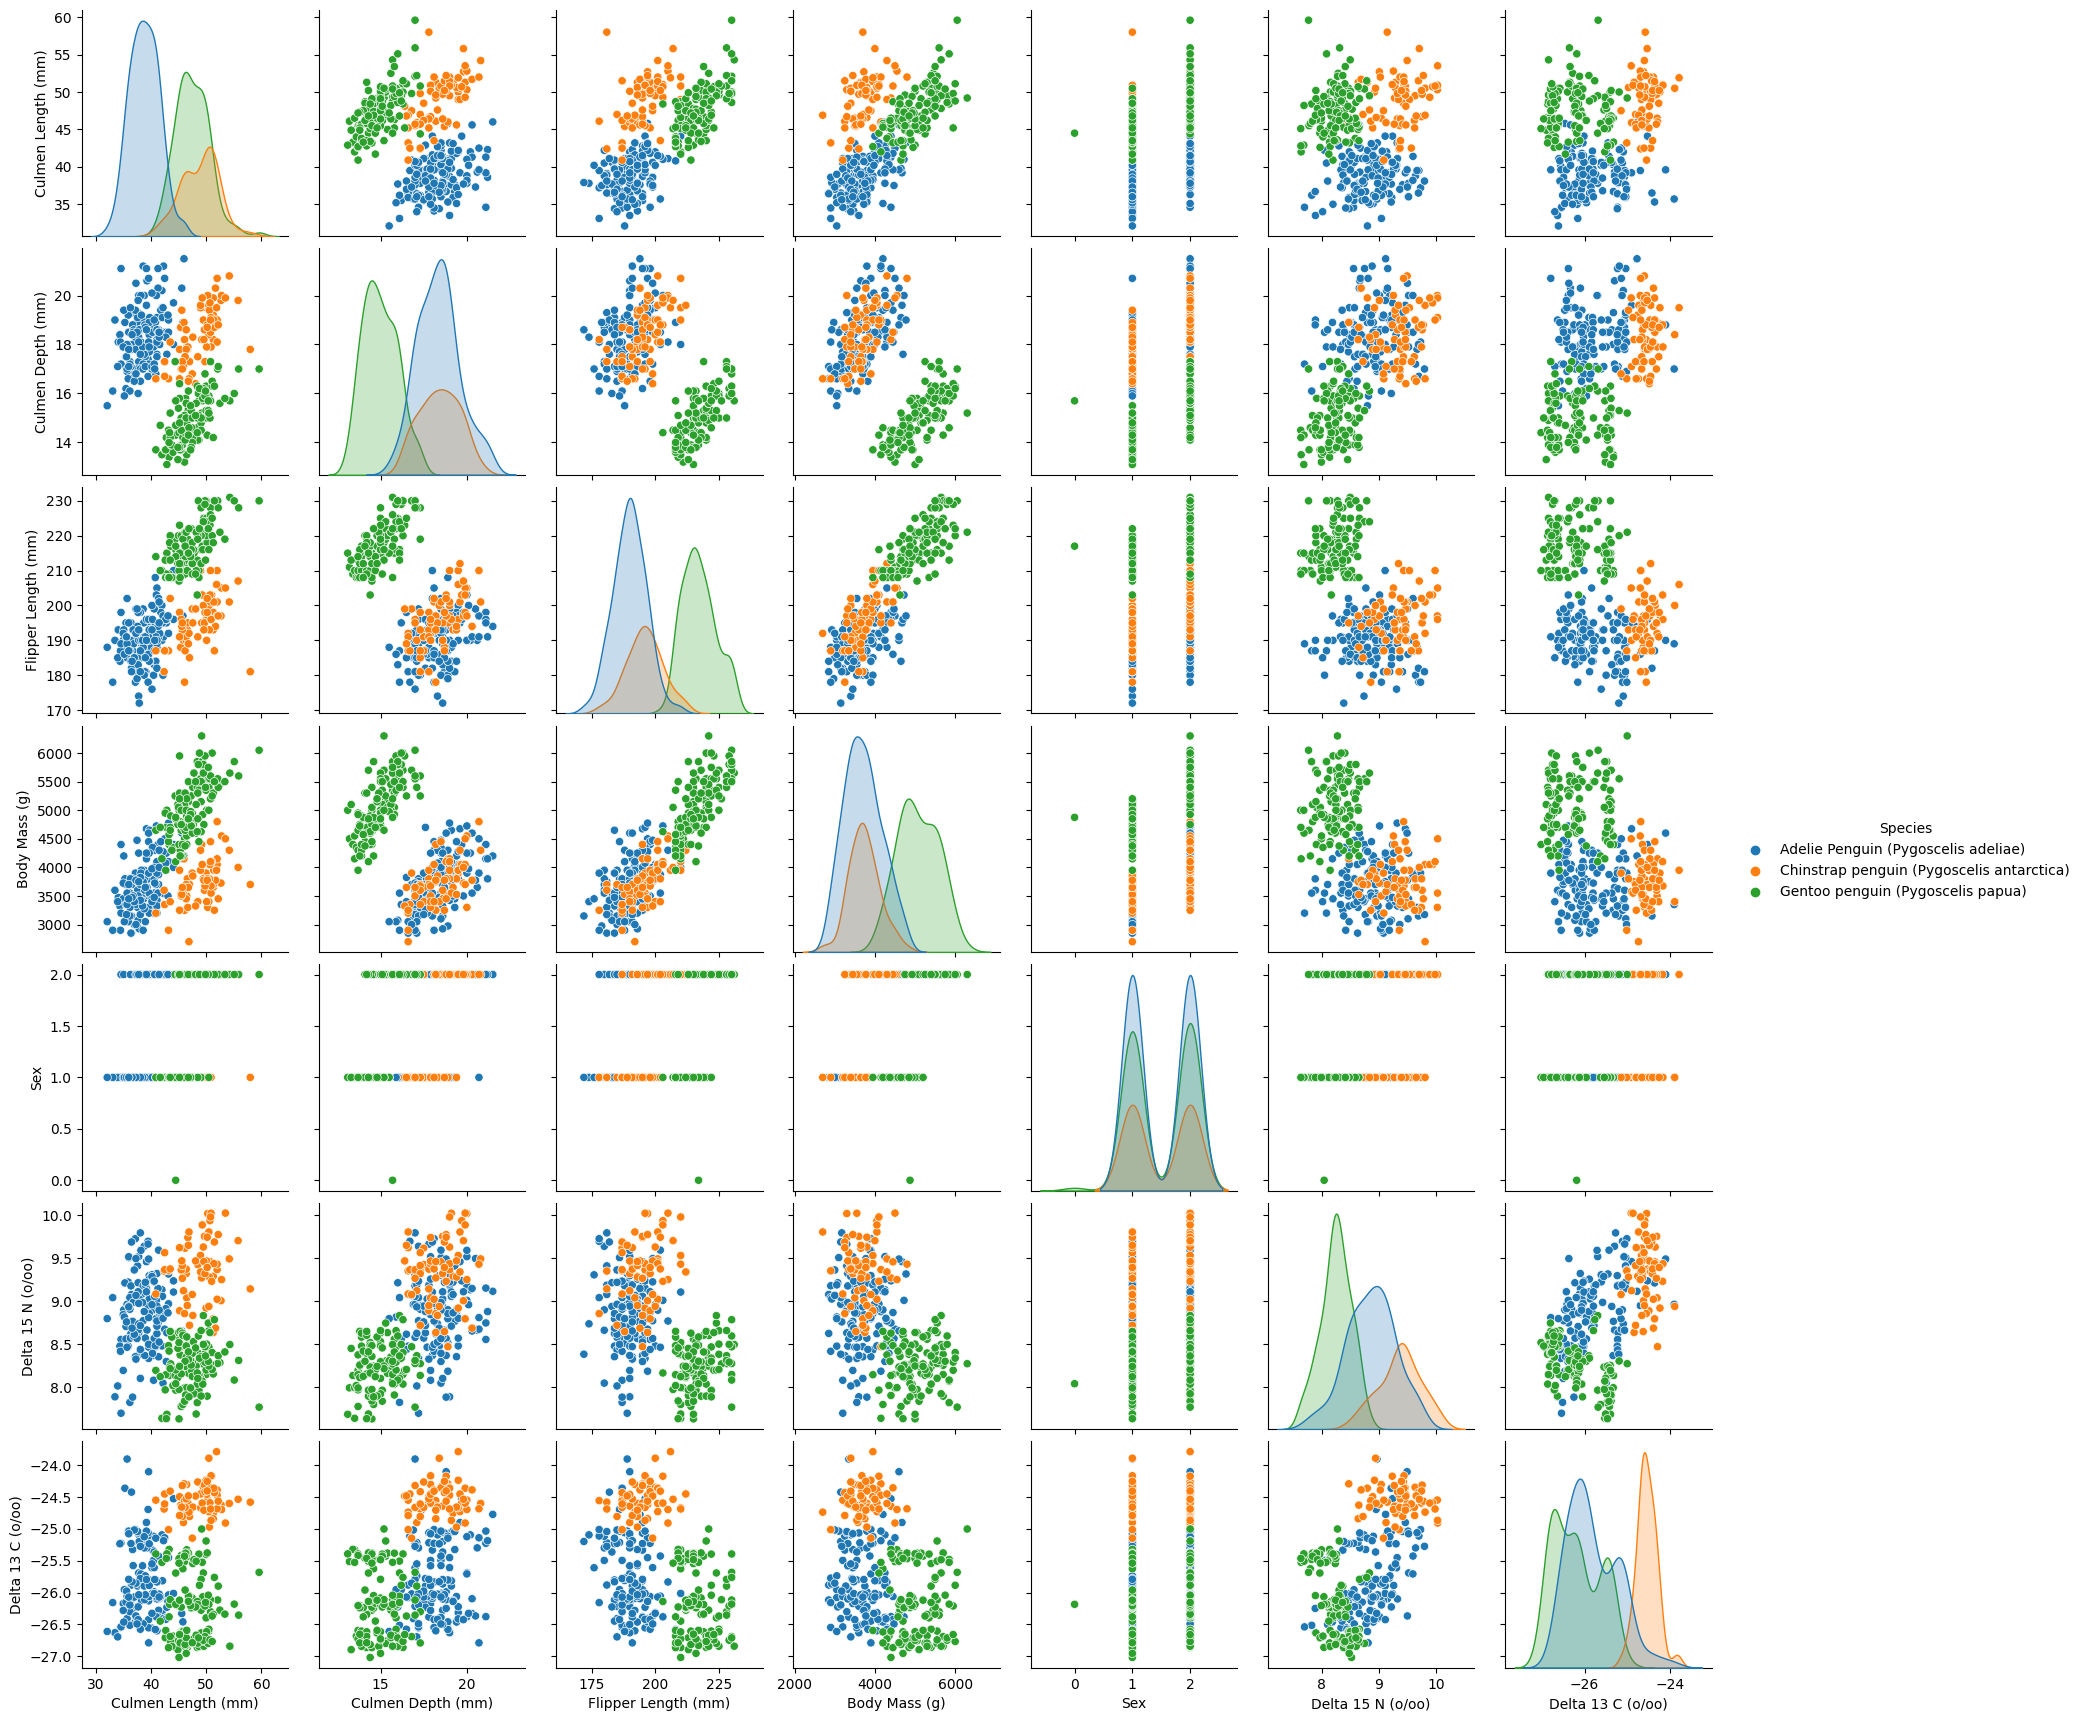

In [4]:
#Explore correlations and data behaviour using a scatterplot matrix for the numeric values
#for our classification purposes we can disregard and drop some of the columns in the table as irrelevant to our classification problem.

data_vis = data.drop(["studyName", "Sample Number", "Region", "Island", "Individual ID", "Date Egg", "Comments", "Stage", "Clutch Completion"], axis = 1)
enc = OrdinalEncoder()
data_vis["Sex"]= enc.fit_transform(data_vis["Sex"].to_numpy().reshape(-1, 1))
sns.pairplot(data_vis, hue="Species")


# Setup data preprocessing

In [5]:
#From the exploratory data analysis it looks like we could further reduced the features considered in this problem
#The ratios of Nitrogen and Carbon isotopes related to the penguins diet are difficult to measure, so these features
#will be excluded from the model as well
#
#Fromt hee first analysis of the database we could see that 3 categories were present in the penguin Sex column - the row 
#the row related ot the penguin with unknown sex will be dropped
data.drop(index=data[data["Sex"]=="."].index, axis = 0, inplace=True)
data.drop(index=data[data["Sex"].isna()].index, axis = 0, inplace=True)
data_red = data.drop(["Sample Number", "Region", "Stage", "Individual ID", "Date Egg", "Comments", "studyName",
                        "Island", "Clutch Completion", "Delta 13 C (o/oo)", "Delta 15 N (o/oo)"], axis =1)

# divide the data in train and test set
X = data_red.drop(["Species"], axis = 1)
y = data_red["Species"]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

#Set up the preprocessing for the numerical and categorical features
categorical_features = ["Sex"]
numerical_features = X_train.select_dtypes(include=np.number).columns.to_list()
categorical_response = y.name

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numerical_transformer, numerical_features)],
        #("cat_response", categorical_response, categorical_transformer)],
        remainder="passthrough"
    )

# Create and apply modelling Pipeline

In [6]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

1.0

# Evaluate model scoring

In [7]:
y_preds = pipe.predict(X_test)
print(classification_report(y_test, y_preds))

                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       1.00      1.00      1.00        31
Chinstrap penguin (Pygoscelis antarctica)       1.00      1.00      1.00        13
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        23

                                 accuracy                           1.00        67
                                macro avg       1.00      1.00      1.00        67
                             weighted avg       1.00      1.00      1.00        67



# Reduced features

In [8]:
#To complicate things a bit let´s reduce the amount of features used to fit the model. We will drop everything 
# except Body mass and  culmen length
data.drop(index=data[data["Sex"]=="."].index, axis = 0, inplace=True)
data.drop(index=data[data["Sex"].isna()].index, axis = 0, inplace=True)
data_red = data.drop(["Sample Number", "Region", "Stage", "Individual ID", "Date Egg", "Comments", "studyName",
                        "Island", "Clutch Completion", "Sex", "Body Mass (g)", "Culmen Length (mm)", "Delta 13 C (o/oo)", "Delta 15 N (o/oo)"], axis =1)

# divide the data in train and test set
X = data_red.drop(["Species"], axis = 1)
y = data_red["Species"]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

#Set up the preprocessing for the numerical and categorical features
numerical_features = X_train.select_dtypes(include=np.number).columns.to_list()
categorical_response = y.name

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features)],
        remainder="passthrough"
    )

# Create modelling pipelines, parameter space, grid and randomized search for multiple estimators

In [24]:

pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier())])

pipe_kn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier())])

pipe_sv = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearSVC())])

grid_params_rf = [{
    "model__n_estimators":[10, 50, 100, 200],
    "model__max_depth":[None, 5, 10, 20, 30],
    "model__max_features": ["sqrt", None],
    "model__max_leaf_nodes": [None, 3, 9],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 4]
}]

grid_params_kn = [{
    "model__n_neighbors":[5, 10, 20],
    "model__weights":["uniform", "distance"]
}]

grid_params_sv = [{
    "model__penalty":["l1", "l2"],
    "model__C":[0.01, 0.1, 0.3, 0.5, 1, 10]
}]

gs_rf = GridSearchCV(
    estimator = pipe_rf,
    param_grid = grid_params_rf,
    scoring = "accuracy", 
    cv = 10
)

gs_kn = GridSearchCV(
    estimator = pipe_kn,
    param_grid = grid_params_kn,
    scoring = "accuracy", 
    cv = 10
)

gs_sv = GridSearchCV(
    estimator = pipe_sv,
    param_grid = grid_params_sv,
    scoring = "accuracy", 
    cv = 10
) 

rs_rf = RandomizedSearchCV(
    estimator = pipe_rf,
    param_distributions = grid_params_rf,
    scoring = "accuracy", 
    cv = 5
)

rs_kn = RandomizedSearchCV(
    estimator = pipe_kn,
    param_distributions= grid_params_kn,
    scoring = "accuracy", 
    cv = 5
)

rs_sv = RandomizedSearchCV(
    estimator= pipe_sv,
    param_distributions= grid_params_sv,
    scoring = "accuracy", 
    cv = 5
) 


# Evaluate The estimators using Randomized Search CV

In [25]:
grids = [rs_rf, rs_kn, rs_sv]

grid_dict = {0: 'Random Forest', 1: 'K Neighbours', 
		2: 'Support Vector Machine'}

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print(f'\nEstimator: {grid_dict[idx]}')	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print(f'Best params: {gs.best_params_}' )
	# Best training data accuracy
	print(f'Best training accuracy: {gs.best_score_}')
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print(f'Test set accuracy score for best params: {classification_report(y_test, y_pred)}')
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print(f'\nClassifier with best test set accuracy: {grid_dict[best_clf]}')


Performing model optimizations...

Estimator: Random Forest
Best params: {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_leaf_nodes': 3, 'model__max_features': 'sqrt', 'model__max_depth': None}
Best training accuracy: 0.7781271837875613
Test set accuracy score for best params:                                            precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.70      1.00      0.83        31
Chinstrap penguin (Pygoscelis antarctica)       0.00      0.00      0.00        13
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        23

                                 accuracy                           0.81        67
                                macro avg       0.57      0.67      0.61        67
                             weighted avg       0.67      0.81      0.73        67


Estimator: K Neighbours


c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Best params: {'model__weights': 'uniform', 'model__n_neighbors': 10}
Best training accuracy: 0.80062893081761
Test set accuracy score for best params:                                            precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.75      0.97      0.85        31
Chinstrap penguin (Pygoscelis antarctica)       0.75      0.23      0.35        13
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        23

                                 accuracy                           0.84        67
                                macro avg       0.83      0.73      0.73        67
                             weighted avg       0.84      0.84      0.80        67


Estimator: Support Vector Machine
Best params: {'model__penalty': 'l2', 'model__C': 0.1}
Best training accuracy: 0.8044723969252271
Test set accuracy score for best params:                                            precision    recall  f1-score   support

      A

c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\david\Documents\ProgettiPython\PenguinClassification\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear fa

# Fine tune parameter search for best performing estimator susing Grid Search CV

In [26]:
grid_params_rf = [{
    "model__n_estimators":[8, 10, 12],
    "model__max_depth":[1, 3, 5],
    "model__max_features": [None],
    "model__max_leaf_nodes": [3, 6],
    "model__min_samples_split": [4, 10],
    "model__min_samples_leaf": [4, 10]
}]

gs_rf = GridSearchCV(
    estimator = pipe_rf,
    param_grid = grid_params_rf,
    scoring = "accuracy", 
    cv = 5
)

In [27]:
# Fit grid search	
gs_rf.fit(X_train, y_train)
# Best params
print(f'Best params: {gs_rf.best_params_}' )
# Best training data accuracy
print(f'Best training accuracy: {gs_rf.best_score_}')
# Predict on test data with best params
y_pred = gs_rf.predict(X_test)
# Test data accuracy of model with best params
print(f'Test set accuracy score for best params: {classification_report(y_test, y_pred)}')



Best params: {'model__max_depth': 3, 'model__max_features': None, 'model__max_leaf_nodes': 6, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 10}
Best training accuracy: 0.8044723969252271
Test set accuracy score for best params:                                            precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.76      1.00      0.86        31
Chinstrap penguin (Pygoscelis antarctica)       1.00      0.23      0.38        13
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        23

                                 accuracy                           0.85        67
                                macro avg       0.92      0.74      0.75        67
                             weighted avg       0.89      0.85      0.81        67

